# Sistema de recomendación de películas
Dado un conjunto de datos de calificaciones otorgadas por usuarios a películas, realiza lo siguiente:

+ Calcula el perfil de cada película usando los géneros como atributos.
+ Emplea un umbral para definir las películas que le gustaron al usuario a partir de la calificación otorgada en escala de 5.
+ Calcula el perfil de cada usuario con los perfiles de las películas que le gustaron. 
+ Realiza una búsqueda de películas con perfil similar al del usuario usando el producto punto como función de similitud. Puedes utilizar fuerza bruta o una biblioteca del vecino más cercano aproximado.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

## Conjunto de datos MovieLens
Para ello usaremos la versión _small_ del conjunto de datos [MovieLens](https://grouplens.org/datasets/movielens/). Esta versión incluye 100,000 calificaciones y 3,600 etiquetas de 9,000 películas realizadas por 600 usarios distintos.


In [2]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2022-10-23 19:14:13--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  3.07MB/s    in 0.3s    

2022-10-23 19:14:13 (3.07 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


Cargamos las calificaciones, las etiquetas y las películas, las cuales se encuentran en archivos CSV.

In [30]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
tags = pd.read_csv('ml-latest-small/tags.csv')
movies = pd.read_csv('ml-latest-small/movies.csv')
links = pd.read_csv('ml-latest-small/links.csv')

Las etiquetas son asignadas por usuarios a una película. Un usuario puede etiquetar distintas películas y una pelicula puede estar etiquetada por múltiples usuarios.  

In [4]:
tags = tags.dropna()
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


Agrupamos las etiquetas por película. 

In [5]:
movietags = tags.groupby(['movieId'])['tag'].apply(set).reset_index(name='tags')
tagcount = Counter(t for r in movietags['tags'] for t in r)
print('{0} películas tienen al menos una etiqueta asociada por usuarios'.format(tags.shape[0]))
print('Hay {0} etiquetas distintas'.format(len(tagcount.keys())))
movietags.head()

3683 películas tienen al menos una etiqueta asociada por usuarios
Hay 1589 etiquetas distintas


,movieId,tags
0,1,"{pixar, fun}"
1,2,"{fantasy, Robin Williams, game, magic board game}"
2,3,"{old, moldy}"
3,5,"{pregnancy, remake}"
4,7,{remake}


Graficamos el histograma de número de etiquetas por película.

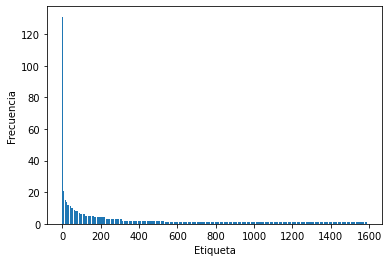

In [6]:
plt.bar(np.arange((len(tagcount.values()))), sorted(tagcount.values(), reverse=True))
plt.xlabel(u'Etiqueta')
plt.ylabel(u'Frecuencia')
plt.show()

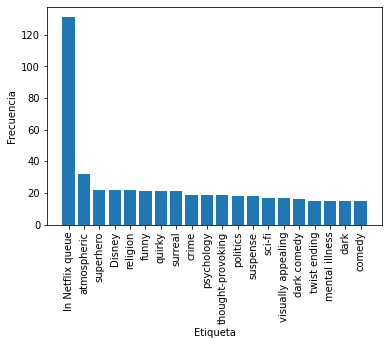

In [7]:
etiqs = [e[0] for e in tagcount.most_common(20)]
vals = [e[1] for e in tagcount.most_common(20)]
plt.bar(etiqs, vals)
plt.xticks(rotation='vertical')
plt.xlabel(u'Etiqueta')
plt.ylabel(u'Frecuencia')
plt.show()

Exploramos las calificaciones y visualizamos sus histogramas.

In [8]:
ratings = ratings.dropna()
print('{0} calificaciones de usuarios a películas'.format(ratings.shape[0]))
ratings.head()

100836 calificaciones de usuarios a películas


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


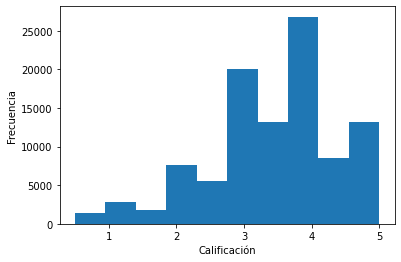

In [9]:
plt.hist(ratings['rating'])
plt.xlabel(u'Calificación')
plt.ylabel(u'Frecuencia')
plt.show()

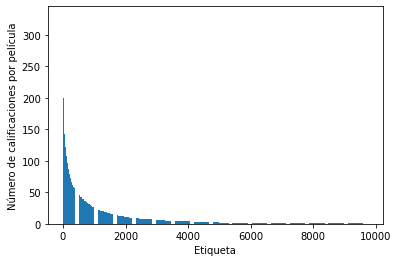

In [10]:
rvals = ratings.groupby(['movieId'])['rating'].size()
plt.bar(np.arange((len(rvals))), sorted(rvals, reverse=True))
plt.xlabel(u'Etiqueta')
plt.ylabel(u'Número de calificaciones por película')
plt.show()

Eliminamos valores faltantes de la tabla de películas, así como las películas sin género asignado (`(no genres listed)`).

In [11]:
movies = movies.dropna()
movies = movies[movies['genres']!='(no genres listed)']
print('{0} películas total'.format(movies.shape[0]))
movies.head()

9708 películas total


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Visualizamos los histogramas de géneros.

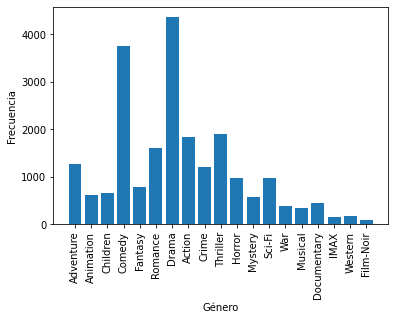

In [12]:
gcount = Counter(g for r in movies['genres'] for g in r.split('|'))
plt.bar(gcount.keys(), gcount.values())
plt.xticks(rotation='vertical')
plt.xlabel(u'Género')
plt.ylabel(u'Frecuencia')
plt.show()

In [13]:
len(gcount.keys())

19

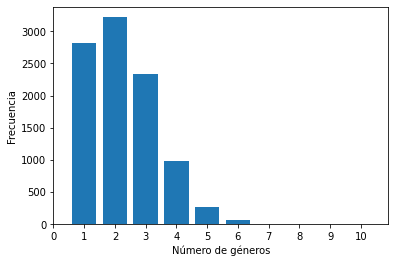

In [14]:
n_genres = Counter(len(r.split('|')) for r in movies['genres'])
plt.bar(n_genres.keys(), n_genres.values())
plt.xlabel(u'Número de géneros')
plt.ylabel(u'Frecuencia')
plt.xticks(range(11))
plt.show()

Examinamos la tabla _links_

In [15]:
links.dropna()
links.sample(5)

,movieId,imdbId,tmdbId
784,1027,102798,8367.0
4998,7716,87635,27171.0
3280,4440,67824,12481.0
7944,95839,216621,16716.0
126,153,112462,414.0


# Aquí se empieza la parte de la tarea
Primero juntamos el id de la pelicula con su nombre y vemos sus géneros.

In [16]:
result = pd.merge(movies, links, on="movieId")
result.head()

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0


In [17]:
result['genres']=result['genres'].apply(lambda x:str.split(x,sep='|'))
result['totgen']=result['genres'].apply(len)
result.head()

,movieId,title,genres,imdbId,tmdbId,totgen
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",114709,862.0,5
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",113497,8844.0,3
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",113228,15602.0,2
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",114885,31357.0,3
4,5,Father of the Bride Part II (1995),[Comedy],113041,11862.0,1


In [18]:
result.shape

(9708, 6)

Ahora vamos a  ponerle uno a cada columna de los diferentes géneros si la pelicula pertence a este, de lo contrario es cero.

In [40]:
s1=pd.get_dummies(s.apply(pd.Series).stack()).sum(level=0)
s1.shape
s1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  """Entry point for launching an IPython kernel.


,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9703,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9704,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9705,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9706,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
df2=pd.concat([result, s1],axis=1)
df2

,movieId,title,genres,imdbId,tmdbId,totgen,Action,Adventure,Animation,Children,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",114709,862.0,5,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",113497,8844.0,3,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",113228,15602.0,2,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",114885,31357.0,3,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),[Comedy],113041,11862.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9703,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]",5476944,432131.0,4,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9704,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]",5914996,445030.0,3,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9705,193585,Flint (2017),[Drama],6397426,479308.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9706,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]",8391976,483455.0,2,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Ahora nos vamos a fijar en los usuarios y sus ratings, primero vamos a eliminar la recomendación si su rating es menor o igual  a 3,ahora vamos a concarenar las peliculas y sus géneros con las que vio cada usuario, ahora vamos a juntar todas las pelicuals que ha visto cada usuario y se le va a sumar los dummies de cada pelicula y su género, los cuales se van a dividir entre el total de peliculas que vio.

In [156]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
print(ratings.shape)
ratings.head()
ratings = ratings.dropna()
ratings = ratings[ratings.rating > 3]
print(ratings.shape)
ratings=pd.concat([ratings, s1],axis=1)
ratings=ratings.drop(['timestamp','movieId','rating'], axis=1)
ratings['tot']=1
ratings = ratings.groupby(['userId']).sum()
ratings.iloc[:,0:] = ratings.iloc[:,0:].div(ratings.tot, axis=0)
ratings=ratings.drop(['tot'], axis=1)
print(ratings.shape)
ratings.index = ratings.index.astype(int)
ratings.head()


(100836, 4)
(61716, 4)
(609, 19)


,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,
1,0.180000,0.140000,0.010000,0.100000,0.355000,0.155000,0.040000,0.485000,0.060000,0.005,0.060000,0.005000,0.015000,0.070000,0.205000,0.065000,0.190000,0.040000,0.015000
2,0.173913,0.000000,0.000000,0.000000,0.347826,0.173913,0.000000,0.608696,0.000000,0.000,0.086957,0.000000,0.000000,0.000000,0.173913,0.086957,0.173913,0.000000,0.000000
3,0.176471,0.176471,0.058824,0.058824,0.294118,0.000000,0.000000,0.529412,0.000000,0.000,0.058824,0.000000,0.000000,0.000000,0.058824,0.294118,0.058824,0.117647,0.000000
4,0.203125,0.109375,0.031250,0.101562,0.390625,0.117188,0.023438,0.492188,0.101562,0.000,0.039062,0.007812,0.031250,0.046875,0.187500,0.046875,0.171875,0.023438,0.039062
5,0.304348,0.217391,0.130435,0.130435,0.173913,0.130435,0.043478,0.391304,0.130435,0.000,0.130435,0.000000,0.043478,0.086957,0.130435,0.086957,0.130435,0.043478,0.000000


In [149]:
df2=pd.concat([result, s1],axis=1)
df2=df2.drop(['movieId','genres','tmdbId','imdbId'], axis=1)
df2=df2.set_index('title')
df2.iloc[:,0:] = df2.iloc[:,0:].div(df2.totgen, axis=0)
df2=df2.drop(['totgen'], axis=1)
df2.head()


,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
title,,,,,,,,,,,,,,,,,,,
Toy Story (1995),0.0,0.200000,0.2,0.200000,0.200000,0.0,0.0,0.000000,0.200000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Jumanji (1995),0.0,0.333333,0.0,0.333333,0.000000,0.0,0.0,0.000000,0.333333,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Grumpier Old Men (1995),0.0,0.000000,0.0,0.000000,0.500000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.0
Waiting to Exhale (1995),0.0,0.000000,0.0,0.000000,0.333333,0.0,0.0,0.333333,0.000000,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0
Father of the Bride Part II (1995),0.0,0.000000,0.0,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


Ahora vamos a entrenar nuestro predictor de vecinos más cercanos con las clasificaciones de peliculas y sus géneros que estos contaran como su dimnesión.
Por ultimo hacemos nuestra función en donde le  pedimos su id de usuario y le vamos a regresar la pelicula que le recomendamos dados sus gustos.

In [183]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(df2, df2.index)

KNeighborsClassifier()

In [195]:
def recomnedación(id):
  print('Dados tus gustos la pelicula que te recomendamos es:',neigh.predict(ratings.iloc[id-1].to_frame().T))

In [196]:
recomnedación(3)

Dados tus gustos la pelicula que te recomendamos es: ['Doctor Who: The Husbands of River Song (2015)']
